In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.extensions import XGate
import math

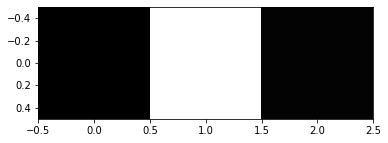

In [33]:
image = np.random.uniform(low=0, high=255, size=(1,3)).astype(int)
plt.imshow(image, cmap = 'gray')

In [34]:
x = int(np.ceil(math.log(image.shape[0], 2)))
if int(x) == 0: x = 1
y = int(np.ceil(math.log(image.shape[1], 2)))
if int(y) == 0: y = 1
q = 8

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()
controls_ = []
for i, _ in enumerate(x_ax):
    controls_.extend([x_ax[i]])
for i, _ in enumerate(y_ax):
    controls_.extend([y_ax[i]])  
for xi in range(image.shape[0]):
    xi_bin = "{0:b}".format(xi).zfill(x_ax.size)
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])  
    qc.barrier()
    for yi in range(image.shape[1]):
        yi_bin = "{0:b}".format(yi).zfill(y_ax.size)
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i]) 
        qc.barrier()
        intensity_bin = "{0:b}".format(image[xi, yi]).zfill(len(color))
        xg = XGate(None).control(len(controls_))
        target = []
        for i, bit in enumerate(intensity_bin):
            if int(bit):
                qc.mcx(controls_, color[i])
        qc.barrier()
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i])
        qc.barrier()
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])
    qc.barrier()

qc.measure(x_ax, range(x_ax.size))
qc.measure(y_ax, range(x_ax.size, x_ax.size+y_ax.size))
qc.measure(color, range(x_ax.size+y_ax.size,x_ax.size+y_ax.size+color.size))

Metrics

| Image size  | Depth measure | # of utilized qubits
| ------------- | ------------- | -------------------|
| 2  | 26  | 10 |
| 4  | 102  | 12 |
| 8  | 389  | 14 |
| 16  | 1491  | 16 |
| 32  | 6180  | 18|
| 64  | 24511  | 20 |
| 128  | 98014  | 22 |
| 256  | 392236  | 24 |

In [35]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 23, # of qubits is 11


In [36]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=80000)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
counts_neqr = (["".join(list(reversed(c))) for c in counts_neqr])
print(counts_neqr)

['01100000000', '11000000000', '00000111000', '10100000000', '01000111001', '00101111110', '10000000000', '11100000000']


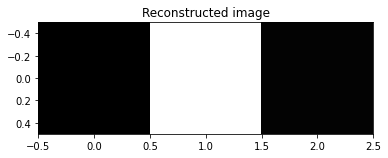

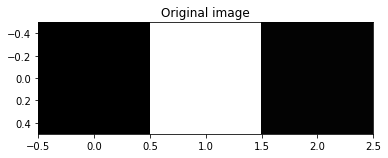

[[ 56. 126.  57.]] 
 [[ 56 126  57]]


In [37]:
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:x], 2), int(item[x:x+y],2), int(item[-q:],2)))
out_image = np.zeros(image.shape)
for pixel in out_pixels:
    if pixel[0]<out_image.shape[0]:
        if pixel[1]<out_image.shape[1]:
            out_image[pixel[0], pixel[1]] = pixel[2]
plt.imshow(out_image, cmap = 'gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap = 'gray')
plt.title('Original image')
plt.show()
print(out_image, '\n', image)